In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [2]:
import copy

In [3]:
from functools import partial
from scipy import optimize

In [4]:
%matplotlib inline

https://amypeniston.com/ditching-excel-for-python/

https://quantecon.org/python-lectures/ - tons of great example notebook. Done by top economists (Sargent). Mix of OO and non-OO just based on what makes the most sense. No need to be dogmatic.

Journal of Open Source Education - https://jose.theoj.org/

# Excel style "What if?" analysis with Python


## A little background and a question

Excel is widely used for building and using models of business problems to explore the impact of various model inputs on key outputs. Built in "what if?" tools such as Excel [Data Tables](https://support.microsoft.com/en-us/office/calculate-multiple-results-by-using-a-data-table-e95e2487-6ca6-4413-ad12-77542a5ea50b) and [Goal Seek](https://support.microsoft.com/en-us/office/use-goal-seek-to-find-the-result-you-want-by-adjusting-an-input-value-320cb99e-f4a4-417f-b1c3-4f369d6e66c7) are well known to power spreadsheet modelers. How might we do similar modeling and analysis using Python? 

While Python has been gaining momentum in the business analytics world, it is often used for data wrangling, analysis and visualization of tablular data using tools like pandas and matplotlib or Seaborn. I use Python all the time for such tasks. But, it got me to thinking. What about those things for which Excel is well suited such as building formula based models and doing sensitivity analysis on these models? What would those look like in Python?

For example, here's a high level screenshot of a model that I assign for homework in my [MIS 4460/5460 Business Analytics class]() (a spreadsheet based modeling class).
It's a really simple model in which we are selling a single product that we produce. There is a fixed cost to producing the product as well as a variable production cost per unit. We can sell the product for some price and we believe that demand for the product is related to the selling price through a power function. Let's assume for now that we have sufficient capacity to produce to demand and that all inputs are deterministic (we'll deal with simulating uncertainty later in this document).

TODO: Insert screenshot

The details aren't so important right now as is the overall structure of the model. There's a few key inputs and some pretty straightforward formulas for computing cost, revenue and profit. Notice the 1-way Data Table being used to explore how profit varies for different selling prices. There's a graph driven by the Data Table and some Text Boxes used for annotation and summeary interpretative comments. There's a button that launches Goal Seek to find the break even selling price and a 2-way Data Table to explore the joint effect of selling price and variable cost. Classic Excel modeling stuff. How might we go about building a similar model using Python?  

What if we wanted to push it a little further and model some of the key inputs with probability distributions to reflect our uncertainty about their values? In the Excel world, we might use add-ins such as @Risk which allow uncertain quantities to be directly modeled with probability distributions. For example, we might have a key input such as the exponent in the power function that relates selling price to demand that is highly uncertain. By modeling it with a probability distribution and then sampling from that distribution many times (essentially by recalcing the spreadsheet) we can generate a bunch of possible values for key outputs (e.g. profit) and use statistics to summarize these outputs using things like histograms and summary stats. Often this type of simulation model is referred to as a *Monte-Carlo* model to suggest repeated sampling from one or more probability distributions within an otherwise pretty static model. If you want to see such models in action, check out my [Simulation Modeling with Excel page](http://www.sba.oakland.edu/faculty/isken/courses/mis5460_w21/simulation.html) from my Business Analytics course. Again, how might we do this with Python?

In the remainder of this document, we'll explore these questions and along the way introduce some basic object-oriented (OO) programming concepts and other slightly more advanced Python techniques. This is aimed at those who might have a strong Excel based background but only a basic familiarity with Python programming. We are going to use a slightly different problem example than the one I've discussed above (we'll save that one for an "exercise for the motivated reader"). I've structured things as follows:

* The bookstore problem
    - Non-OO model for the bookstore problem
    - 1-, 2-, n-way Data Tables with the non-OO model
* Everything is an object in Python
* An OO model for the bookstore problem
    - 1-, 2-, n-way data tables with the OO model
* Goal Seek
    - a non-OO hornet's nest
    - the OO approach
* Monte-Carlo simulation
* Concluding thoughts


## Bookstore model

This example is based on one in the spreadsheet modeling textbook(s) I've used in my classes since 2001. I started out using Practical Management Science by Winston and Albright and switched to their Business Analytics: Data Analysis and Decision Making (Albright and Winston) around 2013ish. In both books, they introduce the "Walton Bookstore" problem in the chapter on Monte-Carlo simulation. Here's the basic problem (with a few modifications):

* we have to place an order for a perishable product (e.g. a calendar)
* there's a known unit cost for each one ordered
* we have a known selling price
* demand is uncertain but we can model it with some simple probability distribution
* for each unsold item, we can get a partial refund of our unit cost
* we need to select the order quantity for our one order for the year; orders can only be in multiples of 25


### Base model - non-OO approach
Starting simple, let's create some initialized variables for the base inputs.

In [5]:
# Base inputs
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50

Assume we've used historical data to estimate the mean and standard deviation of demand. Furthermore, let's pretend that a histogram revealed a relatively normal looking distribution. However, we are going to start by:

* assuming away the uncertainty,
* treat demand as deterministic using the mean,
* we'll do some sensitivity analysis to the demand.

Later, we'll use Monte-Carlo simulation with normally distribution demand.

In [6]:
# Demand parameters
demand_mean = 193
demand_sd = 40

# Deterministic model
demand = demand_mean

Finally, let's set the initial order quantity. This will be the variable we'll focus on in the sensitivity analysis (along with demand). Of course, if we pretend that we know demand is really equal to 193, then we'd only consider ordering 175 or 200 and would pick the one leading to higher profit. Let's set it to 200.

In [7]:
order_quantity = 200

Now we can compute the various cost and revenue components and get to the bottom line profit.

In [8]:
order_cost = unit_cost * order_quantity
sales_revenue = min(order_quantity, demand) * selling_price
refund_revenue = max(0, order_quantity - demand) * unit_refund
profit = sales_revenue + refund_revenue - order_cost

In [9]:
print(profit)

447.5


Of course, working in a Jupyter notebook is different than working in an Excel workbook. If we modify one of the base input values, the value of `profit` is **not** going to magically update.

In [10]:
unit_cost = 8.00
print(profit)

447.5


We either need to:

* rerun the code cell up above that computes the cost, revenue and profit, 
* or make the unit cost change up above when we first initialized and rerun all the cells,
* or take a different approach...

Since it feels like we are going to want to compute profit for different combinations of base input values, it makes sense to create a function to compute it. We'll do that eventually, but let's keep going with this simplistic approach for a bit longer and learn some things about working with vectors.

In [11]:
# Reset entire model
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50

demand = 193

order_quantity = 200

order_cost = unit_cost * order_quantity
sales_revenue = min(order_quantity, demand) * selling_price
refund_revenue = max(0, order_quantity - demand) * unit_refund
profit = sales_revenue + refund_revenue - order_cost

message = f"{'Order Cost':15}{order_cost:10.2f} \n" \
          f"{'Sales Revenue':15}{sales_revenue:10.2f} \n" \
          f"{'Refund':15}{refund_revenue:10.2f} \n" \
          f"{'Profit':15}{profit:10.2f}"

print(message) 

Order Cost        1500.00 
Sales Revenue     1930.00 
Refund              17.50 
Profit             447.50


Notice we've used Python newish approach to formatting strings called [f-strings](https://realpython.com/python-f-strings/). See https://pyformat.info/ for the basics on the format specification (using examples comparing the old % style formatting versus the newer `str.format()` approach) or the [official docs for all the gory details](https://docs.python.org/3/library/string.html#format-specification-mini-language).

### Sensitivity analysis analogous to a 1-way Data Table

To compute `profit` for several different values of `order_quantity`, in Excel we could do a 1-way Data Table. It would give us something like this:

TODO: Insert screenshot of 1-way Data Table.

In Python, we could set `order_quantity` equal to a vector and then recompute profit. Our model should spit out a vector of profit values corresponding to the order quantities in our `order_quantity` vector. The numpy function [arange](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) can be used to create the vector.

In [12]:
order_quantity = np.arange(start=50, stop=301, step=25)
print(order_quantity)

[ 50  75 100 125 150 175 200 225 250 275 300]


**QUESTION** Why do we set `stop=301` instead of 300?

In [13]:
order_cost = unit_cost * order_quantity
sales_revenue = np.minimum(order_quantity, demand) * selling_price
refund_revenue = np.maximum(0, order_quantity - demand) * unit_refund
profit = sales_revenue + refund_revenue - order_cost
print(profit)

[125.  187.5 250.  312.5 375.  437.5 447.5 322.5 197.5  72.5 -52.5]


We can't just use min with a scalar (demand) compared to a vector (order_quantity). Need to use numpy functions since they will do the necessary [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) of demand values to fill out a vector the same size as the `order_quantity` vector. In R, broadcasting is usually referred to as *recycling*.

In [14]:
np.minimum(order_quantity, demand)

array([ 50,  75, 100, 125, 150, 175, 193, 193, 193, 193, 193])

min(order_quantity, demand)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-42-675af9b521e5> in <module>
----> 1 min(order_quantity, demand)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

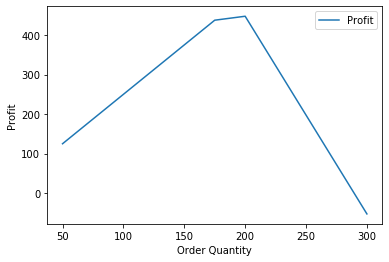

In [15]:
plt.plot(order_quantity, profit, label="Profit")
plt.xlabel('Order Quantity')
plt.ylabel('Profit')
plt.legend()
plt.show()

**QUESTION**
What about a 2-way Data Table? Why can't we just set one of the other inputs (e.g. demand) to a vector and do the same thing we did above?

One approach is to create a profit function that we can call from within a list comprehension.

In [16]:
def bookstore_profit(unit_cost, selling_price, unit_refund, order_quantity, demand):
    '''
    Compute profit in bookstore model
    '''
    order_cost = unit_cost * order_quantity
    sales_revenue = np.minimum(order_quantity, demand) * selling_price
    refund_revenue = np.maximum(0, order_quantity - demand)
    profit = sales_revenue + refund_revenue - order_cost
    return profit

A list comprehension can be used to create an n-way Data Table. Here's a 2-way with demand and order quantity - the other inputs are held constant at their current values and the `bookstore_profit` function is used to compute profit. The list comprehension will generate a list of tuples, (demand, order quantity, profit). To facilitate further analysis, we'll create a pandas DataFrame from this list.

In [17]:
demand_range = np.arange(50, 301, 5)
order_quantity_range = np.arange(50, 301, 25)

In [18]:
# Create data table (as a list of tuples)
data_table_1 = [(d, oq, bookstore_profit(unit_cost, selling_price, unit_refund, oq, d)) 
                 for d in demand_range for oq in order_quantity_range]

# Convert to dataframe
dtbl_1_df = pd.DataFrame(data_table_1, columns=['Demand', 'OrderQuantity', 'Profit'])
dtbl_1_df.head(25)

,Demand,OrderQuantity,Profit
0,50,50,125.0
1,50,75,-37.5
2,50,100,-200.0
3,50,125,-362.5
4,50,150,-525.0
5,50,175,-687.5
6,50,200,-850.0
7,50,225,-1012.5
8,50,250,-1175.0
9,50,275,-1337.5


TODO: Describe plot. Fix legend placement.

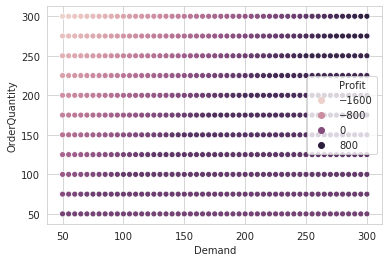

In [19]:
sns.set_style("whitegrid")

sns.scatterplot(x="Demand", y="OrderQuantity", hue="Profit", data=dtbl_1_df)

https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html#mplot3d-tutorial

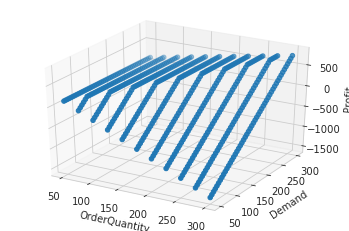

In [20]:
# Make the plot 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtbl_1_df['OrderQuantity'], dtbl_1_df['Demand'], dtbl_1_df['Profit'], 
                cmap=plt.cm.viridis)

ax.set_xlabel('OrderQuantity')
ax.set_ylabel('Demand')
ax.set_zlabel('Profit')

plt.show()

## Everything is an object in Python
Objects are the "things" we create, use, change and share in our Python programs. Objects contain both data about the object and functions for using and changing the object. If you've programmed in Excel VBA, you've already worked with objects and their various properties (data) and methods (functions). For example, consider a `Worksheet` object. One of its properties is `Name` and we can reference it with `Worksheet.Name`. To copy a worksheet, we use `Worksheet.Copy` - `Copy` is a method.

### List objects

In Python, everything is an object and we've already been using objects in this Notebook. It's probably not surprising that something like an array or a list are objects. Let's see what kind of objects they are.

In [21]:
type(order_quantity_range)

numpy.ndarray

In [22]:
type(data_table_1)

list

Let's explore some list methods. To start, we will create a list based on the `order_quantity_range` and then do a few things with the new list.

In [23]:
oq_list = list(order_quantity_range)
print(oq_list)
print(type(oq_list))

[50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
<class 'list'>


A Python `class` is the template from which we create individual objects, called *instances* in our programs. The `list` class lets us create list objects. Python has many built in classes (objects) with numerous predefined methods and properties. 

In [24]:
# Append a new item to end of list
oq_list.append(350)
print(oq_list)

[50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350]


In [25]:
# Reverse the order of our list
oq_list.reverse()
print(oq_list)

[350, 300, 275, 250, 225, 200, 175, 150, 125, 100, 75, 50]


In [26]:
# Reverse it back
oq_list.reverse()
print(oq_list)

[50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350]


Notice that when we used the `append` and `reverse` functions we need to include parentheses just as we do when calling any function. In this case, we aren't passing any arguments into the function, but often we will. 

In [27]:
# Use sort() method to do a reverse sort of our list
oq_list.sort(reverse=True)
print(oq_list)

[350, 300, 275, 250, 225, 200, 175, 150, 125, 100, 75, 50]


What if we forget the parentheses?

In [28]:
oq_list.reverse

<function list.reverse()>

Python just tells us that `reverse` is a function. It's also telling us that `reverse`, a function, is also an object. Yes, functions are objects, too, in Python. That means we can do things like pass them to other functions or modify some of their properties. Why would we ever want to do this? We'll get to that.

I'm sure you already know how to get items from a list by their index number.

In [29]:
# Get the first element from the list
oq_list[0]

350

The bracket notation is really just a convenient shorthand for calling one of the built in methods of list objects. We can use Python `dir` function to see all of the attributes of any object.

In [30]:
print(dir(oq_list))

['__add__', '__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']


Many of the attributes have both leading and trailing double underscores, known as "dunder" attributes. These are just special names reserved by Python for particular uses. You'll see use of both single and double underscores, as both leading and trailing characters. To dig deeper, check out https://dbader.org/blog/meaning-of-underscores-in-python.

In our example, using brackets to access a list item is really just a different way of calling the `__getitem__` dunder method.

In [31]:
oq_list.__getitem__(0)

350

Also notice that all of these functions worked *in place* - they operated directly on the object `oq_list` and modified it. Some methods will create a new instance of the object and if you want to "save" it, you'll have to assign the result back to your original object or create a new variable. If you've used R, you might recall that the dplyr package **never** modifies dataframes in place. The dplyr functions (e.g. `select`, `mutate`, `filter`, ...) always return new objects and we hav3 to "catch the results" by assigning to a variable if we wanted to actually modify our dataframe.

Returning to our list example, we'll make a copy and explore a bit.

In [32]:
new_list = oq_list.copy()    # Make a copy and save to new variable
print(new_list)              # Check out the new variable
print(new_list == oq_list)   # Does the new variable have the same value as the old variable?
print(type(new_list) == type(oq_list))  # Are the two variables of the same type?
print(new_list is oq_list)   # Is the new variable actually the same object as the old variable?
print(id(oq_list), id(new_list))  # Every object has its own unique id number. Use id() to see it.

[350, 300, 275, 250, 225, 200, 175, 150, 125, 100, 75, 50]
True
True
False
140255257959488 140255244415168


The two lists have the same value and are of the same datatype, but are **not** the same object.

**QUESTION** If we reversed one of the two lists, would they still be considered to have the same value? In other words, does order matter with lists?

Care must be taken when copying lists.

In [33]:
print(oq_list)

[350, 300, 275, 250, 225, 200, 175, 150, 125, 100, 75, 50]


In [34]:
new_oq_list = oq_list
print(new_oq_list)
oq_list.reverse()
print(new_oq_list)
print(id(oq_list), id(new_oq_list))

[350, 300, 275, 250, 225, 200, 175, 150, 125, 100, 75, 50]
[50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 350]
140255257959488 140255257959488


Yikes! As you can see from the id numbers, both list variables point to the same object in memory. Changing one list, changes the other - they're the same object. So, how do you safely copy lists? You use the `copy` method like we did above.

Let's look at the attributes of a `numpy.array` object and see how that compares to a list. They both are a data structure that allows us to store a bunch of values and get at them via an index number. What differences do you think these two data structures might have?

In [35]:
print(dir(order_quantity_range))

['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rlshift_

Wow, [numpy arrays](https://jakevdp.github.io/PythonDataScienceHandbook/02.02-the-basics-of-numpy-arrays.html) have a whole lot more going on under the hood than do lists. They play a huge role in doing data science work in Python with many packages using numpy to store and work with data. Notice that there are various mathematical methods such as `sum` and `mean` and methods to convert arrays to lists and strings using the obviously named methods. We see that there is a `dtype` property - it tells us the data type of the array. Our array stores 64bit integers.

In [36]:
order_quantity_range.dtype

dtype('int64')

**QUESTIONS** Why don't we use parens with `dtype`? Why don't list objects have a `dtype` property?

### What about numbers?
Are things like integers and floating point numbers actually objects?

In [37]:
print(unit_cost)
print(type(unit_cost))
print(dir(unit_cost))

7.5
<class 'float'>
['__abs__', '__add__', '__bool__', '__class__', '__delattr__', '__dir__', '__divmod__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getformat__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__int__', '__le__', '__lt__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__pos__', '__pow__', '__radd__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmod__', '__rmul__', '__round__', '__rpow__', '__rsub__', '__rtruediv__', '__set_format__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__trunc__', 'as_integer_ratio', 'conjugate', 'fromhex', 'hex', 'imag', 'is_integer', 'real']


Yep. Try out some of the attributes.

### Writing our own classes
While Python has many useful built in classes, true [object-oriented programming](https://en.wikipedia.org/wiki/Object-oriented_programming) (OOP) involves creating our own classes from which we can create object instances that are useful for the problem at hand. Python is an OOP language but it does **not** force you to create classes if you don't want to. You can write purely procedural code, some blend of [procedural](https://en.wikipedia.org/wiki/Procedural_programming), object oriented and [functional programming](https://en.wikipedia.org/wiki/Functional_programming). We aren't going to get into debates about which programming paradigm is the "best". There are times when OOP makes a lot of sense, and for those times, we'll use it. Other times, simply creating useful functions (such as the `bookstore_profit` function we used earlier) is the appropriate thing to do.

Many business analysts who learn Excel VBA, don't realize that you can actually create classes in VBA. Most stick with using the built in Excel objects.

## An OO version of the Bookstore Model

Let's create an OO version of the Bookstore Model and figure out how to do n-way data tables just as we did with the non-OO version of the model. Then we'll go on and figure out how to duplicate the functionality of Excel's Goal Seek tool in Python. It's not clear whether the non-OO or the OO version of our model will ultimately prove best for this use case. Regardless, we'll learn a few things along the way.

As an aside, there's a very useful site aimed at using Python quantitative economics and finance - https://quantecon.org/. Within there are some terrific notebooks on various Python topics. Here are two related to OOP:

* https://python-programming.quantecon.org/oop_intro.html
* https://python-programming.quantecon.org/python_oop.html

### Initial design of the BookstoreModel class
It seems like we would want all of the base inputs such as unit cost, selling price, unit refund, order quantity and demand to be attributes (properties) of the class. Here's the start of our class definition code:

In [38]:
class BookstoreModel():
    def __init__(self, unit_cost, selling_price, unit_refund, order_quantity, demand):
        self.unit_cost = unit_cost
        self.selling_price = selling_price
        self.unit_refund = unit_refund
        self.order_quantity = order_quantity
        self.demand = demand

Some important things of note:

* we use the keyword `class` followed by the name of our class.
* by convention, class names are capitalized (each word if multi-word).
* the class declaration looks a little like defining a function but we use `class` instead of `def`.
* there's nothing in the parentheses following the class name. We'll defer talking about this for now.
* there's a single method (function) defined within the class and it is called `__init__`. From earlier in this document we know that this must be a built in dunder method that has some special purpose. From its name you've probably already guessed that it's the function called when a new object instance is first created. If you've programmed in Java or C++, this is kind of like a constructor.
* the first argument to the `__init__` function is `self` and represents the object instance being created.
* the remaining arguments to the `__init__` function are values that we want to use in the function. In this case, we simply want to create object properties corresponding to the base inputs for the bookstore model.
* the rest of the lines within the `__init__` function are initializing our object properties to the values passed in. 
* in order to reference (i.e. to get the value or set the value) an object property, we always preface the property with the `self` object, e.g., `self.unit_cost`.
* if you've programmed in Java you might be used to using "setters and getters". In general [we don't do that in Python](https://www.python-course.eu/python3_properties.php) and instead just reference the property directly using dot notation.

Well, our class isn't super useful yet, but let's try it out. Make sure you run the code chunk above that defines the BookstoreModel class.

In [39]:
# Reset the base inputs
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50
demand = 193
order_quantity = 200

# Create a new BookstoreModel object
model_1 = BookstoreModel(unit_cost, selling_price, unit_refund, order_quantity, demand)

Let's print out one of the properties.

In [40]:
print(model_1.unit_cost)

7.5


What happens if we try to print the model object itself?

In [41]:
print(model_1)

Ok, not the most useful but we do see that we've got an object of the right type and that the object lives in the `__main__` *namespace*. Namespaces are important in Python. They're even mentioned in the Zen of Python. You can [learn more about namespaces here](https://realpython.com/python-namespaces-scope/).

In [42]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


If you look back at our `bookstore_profit` function, you'll see that it first computes the various cost and revenue components and then computes profit from that. So, it would seem usefu to add some methods to our BookstoreModel class that computed these things.

In [43]:
class BookstoreModel():
    def __init__(self, unit_cost, selling_price, unit_refund, order_quantity, demand):
        self.unit_cost = unit_cost
        self.selling_price = selling_price
        self.unit_refund = unit_refund
        self.order_quantity = order_quantity
        self.demand = demand
        
    def order_cost(self):
        """Compute total order cost"""
        return self.unit_cost * self.order_quantity
    
    def sales_revenue(self):
        """Compute sales revenue"""
        return np.minimum(self.order_quantity, self.demand) * self.selling_price
    
    def refund_revenue(self):
        """Compute revenue from refunds for unsold items"""
        return np.maximum(0, self.order_quantity - self.demand)
    
    def profit(self):
        '''
        Compute profit
        '''
        profit = self.sales_revenue() + self.refund_revenue() - self.order_cost()
        return profit

A few important things to note:
* we added four new object functions (methods)
* each method only takes the `self` object as an input argument. We don't pass in the properties such as unit_cost or order_quantity. We don't need to since self knows about these things via its properties.
* within each method we have to use `self.someproperty` in our expressions
* the `profit` method calls some of the other methods and when it does, it prefaces the method with `self.` and follows it with empty parens. The `self` object is implicitly passed.
* each method returns a value
* each method has a simple docstring

Before we can test out our enhanced class, we need to run the code cell above and we need to create a new object instance based on the updated class definition.

In [44]:
# Create a new BookstoreModel object
model_2 = BookstoreModel(unit_cost, selling_price, unit_refund, order_quantity, demand)

In [45]:
print(model_2.sales_revenue())
print(model_2.profit())

1930.0
437.0


It would nice to have a way to print out a succinct summary of a BookstoreModel object. Let's start by just listing out the properties. We can use the Python `vars` function to help. This StackOverflow post has some good info on getting a dictionary of object properties:

https://stackoverflow.com/questions/61517/python-dictionary-from-an-objects-fields

In [46]:
vars(model_2)

{'unit_cost': 7.5,
 'selling_price': 10.0,
 'unit_refund': 2.5,
 'order_quantity': 200,
 'demand': 193}

In [47]:
print(vars(model_2))

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


The Pythonic way for creating a string representation of an object is to implement a `__str__` dunder function for our object. This function needs to return a string. Notice that the `vars` function returns a dictionary. You can learn more about `__str__` and the related `__repr__` dunder functions at https://dbader.org/blog/python-repr-vs-str. In a nutshell, we use `__str__` to create "pretty" string representations of an object for our user and `__repr__` for an unambiguous string representation that includes the object type.

In [48]:
class BookstoreModel():
    def __init__(self, unit_cost, selling_price, unit_refund, order_quantity, demand):
        self.unit_cost = unit_cost
        self.selling_price = selling_price
        self.unit_refund = unit_refund
        self.order_quantity = order_quantity
        self.demand = demand
        
    def order_cost(self):
        """Compute total order cost"""
        return self.unit_cost * self.order_quantity
    
    def sales_revenue(self):
        """Compute sales revenue"""
        return np.minimum(self.order_quantity, self.demand) * self.selling_price
    
    def refund_revenue(self):
        """Compute revenue from refunds for unsold items"""
        return np.maximum(0, self.order_quantity - self.demand)
    
    def profit(self):
        '''
        Compute profit
        '''
        profit = self.sales_revenue() + self.refund_revenue() - self.order_cost()
        return profit
    
    def __str__(self):
        """
        String representation of bookstore inputs
        """
        return str(vars(self))

Notice we wrapped `vars` with `str` to convert the dictionary to a string.

In [49]:
# Reset the base inputs
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50
demand = 193
order_quantity = 200

# Create a new BookstoreModel object
model_3 = BookstoreModel(unit_cost, selling_price, unit_refund, order_quantity, demand)

In [50]:
print(model_3)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


**CHALLENGE** Modify the `__str__` function so that it also shows the computed value of `order_cost`, `sales_revenue`, `refund_revenue` and `profit`.

### 1-way Data Table with OO model
Seems entirely plausible that we could simple set one of the inputs to an array of values and then call the `profit` method.

In [51]:
# Set property equal to an array
model_3.order_quantity = np.arange(50, 301, 25)

In [52]:
# Can we compute an array of profits? Yep.
model_3.profit()

array([ 125. ,  187.5,  250. ,  312.5,  375. ,  437.5,  437. ,  274.5,
        112. ,  -50.5, -213. ])

What about a 2-way data table using the OO model? We can't use the same direct array passing approach because of ...

In [ ]:
# This won't work unless the two arrays are the same size - can't broadcast.
# Also, even if same size, doesn't do all combinations, just aligned elements.
demand_range = np.arange(70, 321, 5)
order_quantity_range = np.arange(70, 321, 10)    # Broadcast error
# order_quantity_range = np.arange(70, 321, 5)   # Doesn't do all combinations

# Method 1: Set property equal to an array
model_3.demand = demand_range
model_3.order_quantity = order_quantity_range

model_3.profit()

Recall that for the non-OO model, we could easily do an n-way data table using a list comprehension that made use of the `bookstore_profit` function because we could explicitly loop over ranges of any subset of the input variables and call the `bookstore_profit` function with all of the input arguments specified. We can't do that with the OO model because the `profit` function is a method of the object and we don't pass it any input arguments other than `self`? So, we need a way to loop over alll the input ranges and update the bookstore model object's input attributes and then call the `profit` method.

### A decision point
An end user modeler analagous to your basic Excel power user isn't going to write OO code to do a Data Table. The list comprehension approach based on a global function (i.e. the non-OO model) is much more likely. However, a relatively generic Data Table function could be implemented in an OO way and be quite reusable. Also, we still want to implement Goal Seek and it's not clear whether the OO or non-OO approach makes the most sense.

Well, let's forge ahead and design and create a Python based Data Table function that accepts an OO BookstoreModel object as one of its inputs. Surely, we'll learn some things along the way.

#### Adding an `update` method.
Since were are going to need to repeatedly update some subset of the input parameters, let's add an `update` method to the BookstoreModel class that takes a dictionary of property, value pairs. The question is, how do we update object attributes from a dictionary specifying the attribute and the new value? This StackoverFlow post was quite helpful:

https://stackoverflow.com/questions/2466191/set-attributes-from-dictionary-in-python

The idea is that we use Python's `setattr` function. Using [`setattr`](https://www.w3schools.com/python/ref_func_setattr.asp) is really easy:

    setattr(object, attribute name, attribute value)
    
As a specific example, it can be used like this.

In [53]:
model_4 = BookstoreModel(unit_cost, selling_price, unit_refund, order_quantity, demand)
print(model_4)

# We want to update a existing model object with these parameter values
new_params = {'unit_cost': 8.5, 'order_quantity': 250}

# Iterate over the keys in new_params
for key in new_params:
            setattr(model_4, key, new_params[key])
        
print(model_4)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}
{'unit_cost': 8.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 250, 'demand': 193}


Okay, here's our updated BookstoreModel class. Note that I've also added a convenience method called `reset` that just resets all the input parameters to their initial values for testing. In order to do this we need to store the initial input values in a dictionary. I've named that dictionary variable as `_initial_inputs`. The leading underscore is a Python convention suggesting that this variable is meant to be an "internal" or "private" variable. It's not really private. I've also changed to keyword arguments with default values.

In [80]:
class BookstoreModel():
    def __init__(self, unit_cost=0, selling_price=0, unit_refund=0, 
                 order_quantity=0, demand=0):
        self.unit_cost = unit_cost
        self.selling_price = selling_price
        self.unit_refund = unit_refund
        self.order_quantity = order_quantity
        self.demand = demand
        
        # Store initial inputs to use in reset method
        self._initial_inputs = vars(self)
        
    def update(self, param_dict):
        """
        Update parameter values
        """
        for key in param_dict:
            setattr(self, key, param_dict[key])
        
    def order_cost(self):
        return self.unit_cost * self.order_quantity
    
    def sales_revenue(self):
        return np.minimum(self.order_quantity, self.demand) * self.selling_price
    
    def refund_revenue(self):
        return np.maximum(0, self.order_quantity - self.demand)
    
    def profit(self):
        '''
        Compute profit in bookstore model
        '''
        profit = self.sales_revenue() + self.refund_revenue() - self.order_cost()
        return profit
    
    def reset(self):
        """
        Reset model attributes to initial values. 
        """
        self.update(self._initial_inputs)
    
    def __str__(self):
        """
        Print dictionary of object attributes but don't include the _initial_inputs dict.
        """
        return str({key: val for (key, val) in vars(self).items() if key[0] != '_'})

Let's try out our `update` and `reset` methods.

In [81]:
model_5 = BookstoreModel(unit_cost, selling_price, unit_refund, order_quantity, demand)
model_5.reset()
print(model_5)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


Now let's try our new `update` method.

In [82]:
new_params = {'unit_cost': 8.5, 'order_quantity': 250}
model_5.update(new_params)
print(model_5)

{'unit_cost': 8.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 250, 'demand': 193}


#### Learning from the ideas and code from scikit-learn

[Scikit-learn](https://scikit-learn.org/stable/index.html) is an extremely popular Python package for building, testing and using machine learning models. In thinking about the input values for an n-way data table, it feels like it would like the parameter grid for a hyperparameter grid search in scikit learn. Can we borrow some of their patterns?

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

https://scikit-learn.org/stable/modules/grid_search.html#grid-search

Example from User Guide shows passing in two different grids to explore as a list of dicts. Notice that each dict is like the setup for an Excel Data Table.

    param_grid = [
      {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
      {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
     ]
     
     
For example, the `GridSearchCV` takes and estimator object and a parameter grid object. The parameter grid is a dict or list of dicts in which the keys are the parameter names. SKLearn implements a `ParameterGrid` class. Looking at its source, the docstring contains the following example. Notice that the result of `ParameterGrid(param_grid)` is a list of dicts in which each dict contains a specific combination of the parameter values, i.e., it generates all the combos. The second example shows the value of accepting a list of dicts as `param_grid` to avoid ridiculous or nonsensical combinations (e.g. the linear kernal has no gamma param).

    Examples
    --------
    >>> from sklearn.model_selection import ParameterGrid
    >>> param_grid = {'a': [1, 2], 'b': [True, False]}
    >>> list(ParameterGrid(param_grid)) == (
    ...    [{'a': 1, 'b': True}, {'a': 1, 'b': False},
    ...     {'a': 2, 'b': True}, {'a': 2, 'b': False}])
    True
    >>> grid = [{'kernel': ['linear']}, {'kernel': ['rbf'], 'gamma': [1, 10]}]
    >>> list(ParameterGrid(grid)) == [{'kernel': 'linear'},
    ...                               {'kernel': 'rbf', 'gamma': 1},
    ...                               {'kernel': 'rbf', 'gamma': 10}]
    True
    >>> ParameterGrid(grid)[1] == {'kernel': 'rbf', 'gamma': 1}
    True


Hmm, we could use this class directly.

In [57]:
from sklearn.model_selection._search import ParameterGrid

In [58]:
dt_param_ranges = {'demand': np.arange(70, 321, 25),
                'order_quantity': np.arange(70, 321, 50)}

In [59]:
dt_param_grid = list(ParameterGrid(dt_param_ranges))
dt_param_grid

[{'demand': 70, 'order_quantity': 70},
 {'demand': 70, 'order_quantity': 120},
 {'demand': 70, 'order_quantity': 170},
 {'demand': 70, 'order_quantity': 220},
 {'demand': 70, 'order_quantity': 270},
 {'demand': 70, 'order_quantity': 320},
 {'demand': 95, 'order_quantity': 70},
 {'demand': 95, 'order_quantity': 120},
 {'demand': 95, 'order_quantity': 170},
 {'demand': 95, 'order_quantity': 220},
 {'demand': 95, 'order_quantity': 270},
 {'demand': 95, 'order_quantity': 320},
 {'demand': 120, 'order_quantity': 70},
 {'demand': 120, 'order_quantity': 120},
 {'demand': 120, 'order_quantity': 170},
 {'demand': 120, 'order_quantity': 220},
 {'demand': 120, 'order_quantity': 270},
 {'demand': 120, 'order_quantity': 320},
 {'demand': 145, 'order_quantity': 70},
 {'demand': 145, 'order_quantity': 120},
 {'demand': 145, 'order_quantity': 170},
 {'demand': 145, 'order_quantity': 220},
 {'demand': 145, 'order_quantity': 270},
 {'demand': 145, 'order_quantity': 320},
 {'demand': 170, 'order_quantity

Perfect! We have a list of dictionaries, each of which contains one of the combinations of the `demand` and `order_quantity` attributes that we want in our data table. Isn't it nice that we just implemented an `update` method that takes just such a dictionary as its input. Almost like we planned it. :)

While there's nothing wrong with leveraging the skikit-learn library for this task (after all, reusing objects is one of the whole reasons for OOP), we really don't need all the generality provided by its `ParameterGrid` class. We just need to do some careful iteration through our dictionary of input ranges to create the same output. It will give us a chance to use the very useful [itertools library](https://docs.python.org/3/library/itertools.html). 

In [60]:
from itertools import product

In [61]:
# Look at the key, value pairs (tuples) in dt_param_ranges dictionary
dt_param_ranges.items()

dict_items([('demand', array([ 70,  95, 120, 145, 170, 195, 220, 245, 270, 295, 320])), ('order_quantity', array([ 70, 120, 170, 220, 270, 320]))])

Now we can use [tuple unpacking](https://docs.python.org/3.6/tutorial/controlflow.html#unpacking-argument-lists) along with the [zip function](https://www.w3schools.com/python/ref_func_zip.asp) to get two tuples. One tuple will get stored in the variable `keys` and the other in `values`.

In [62]:
print("The original tuples")
print(*dt_param_ranges.items())
print("\nThe zipped tuples")
keys, values = zip(*dt_param_ranges.items())
print(keys, values)

The original tuples
('demand', array([ 70,  95, 120, 145, 170, 195, 220, 245, 270, 295, 320])) ('order_quantity', array([ 70, 120, 170, 220, 270, 320]))

The zipped tuples
('demand', 'order_quantity') (array([ 70,  95, 120, 145, 170, 195, 220, 245, 270, 295, 320]), array([ 70, 120, 170, 220, 270, 320]))


Now we have a tuple of the keys, `('demand', 'order_quantity')` and a tuple containing the two arrays of associated values.

What we need next is a way to get all the combinations of the values in the two arrays. This is a perfect job for the `itertools.product` function. Here's a simple example of what `product` does.

In [63]:
colors = ['red', 'blue', 'green']
intensities = ['pale', 'bright']
for pair in product(intensities, colors):
    print(pair)

('pale', 'red')
('pale', 'blue')
('pale', 'green')
('bright', 'red')
('bright', 'blue')
('bright', 'green')


The `values` variable is a tuple (that needs unpacking) containing the two arrays for which we want the `product`. I'll turn the result into a list so we can see it. Try it without the list to see what you get.

In [64]:
list(product(*values))

[(70, 70),
 (70, 120),
 (70, 170),
 (70, 220),
 (70, 270),
 (70, 320),
 (95, 70),
 (95, 120),
 (95, 170),
 (95, 220),
 (95, 270),
 (95, 320),
 (120, 70),
 (120, 120),
 (120, 170),
 (120, 220),
 (120, 270),
 (120, 320),
 (145, 70),
 (145, 120),
 (145, 170),
 (145, 220),
 (145, 270),
 (145, 320),
 (170, 70),
 (170, 120),
 (170, 170),
 (170, 220),
 (170, 270),
 (170, 320),
 (195, 70),
 (195, 120),
 (195, 170),
 (195, 220),
 (195, 270),
 (195, 320),
 (220, 70),
 (220, 120),
 (220, 170),
 (220, 220),
 (220, 270),
 (220, 320),
 (245, 70),
 (245, 120),
 (245, 170),
 (245, 220),
 (245, 270),
 (245, 320),
 (270, 70),
 (270, 120),
 (270, 170),
 (270, 220),
 (270, 270),
 (270, 320),
 (295, 70),
 (295, 120),
 (295, 170),
 (295, 220),
 (295, 270),
 (295, 320),
 (320, 70),
 (320, 120),
 (320, 170),
 (320, 220),
 (320, 270),
 (320, 320)]

Finally, we need to zip each of these tuples with the `keys` variable and turn the resulting tuple into a dictionary. Let's recall what it contains:

In [65]:
keys

('demand', 'order_quantity')

In [66]:
list(zip(keys, (70, 120)))

[('demand', 70), ('order_quantity', 120)]

In [67]:
dict(zip(keys, (70, 120)))

{'demand': 70, 'order_quantity': 120}

Ok, just put all these ideas together.

In [68]:
param_grid = []

keys, values = zip(*dt_param_ranges.items())

for v in product(*values):
    params = dict(zip(keys, v))
    param_grid.append(params)
        
print(param_grid)

[{'demand': 70, 'order_quantity': 70}, {'demand': 70, 'order_quantity': 120}, {'demand': 70, 'order_quantity': 170}, {'demand': 70, 'order_quantity': 220}, {'demand': 70, 'order_quantity': 270}, {'demand': 70, 'order_quantity': 320}, {'demand': 95, 'order_quantity': 70}, {'demand': 95, 'order_quantity': 120}, {'demand': 95, 'order_quantity': 170}, {'demand': 95, 'order_quantity': 220}, {'demand': 95, 'order_quantity': 270}, {'demand': 95, 'order_quantity': 320}, {'demand': 120, 'order_quantity': 70}, {'demand': 120, 'order_quantity': 120}, {'demand': 120, 'order_quantity': 170}, {'demand': 120, 'order_quantity': 220}, {'demand': 120, 'order_quantity': 270}, {'demand': 120, 'order_quantity': 320}, {'demand': 145, 'order_quantity': 70}, {'demand': 145, 'order_quantity': 120}, {'demand': 145, 'order_quantity': 170}, {'demand': 145, 'order_quantity': 220}, {'demand': 145, 'order_quantity': 270}, {'demand': 145, 'order_quantity': 320}, {'demand': 170, 'order_quantity': 70}, {'demand': 170, 

Voila! We've recreated the same output as `ParameterGrid` gave us.

#### Creating the data_table function

Our plan is to create a function that takes three inputs:

* a model object such as model_5,
* a dictionary containing the input attributes and associated ranges for the data table such as dt_param_ranges,
* a list of outputs which are methods of the the model object; for example ['profit']

Since we don't want the `data_table` function to modify our passed in model object, we'll create a copy of the model within the function. As we saw when copying list objects, we need to be careful when copying user defined objects. We'll create what is known as a *deep copy* using the `copy` library. Learn more about [shallow and deep copying here](https://docs.python.org/3/library/copy.html).

Then we'll generate our parameter grid. I like to think of each element in the parameter grid, e.g. `{'demand': 295, 'order_quantity': 270}`, as a *scenario*. We loop over all the scenarios in the grid, updating the model copy and computing the requested outputs. For each scenario, we'll end up with a dictionary containing both the inputs and outputs. For example, `{'demand': 295, 'order_quantity': 270, 'profit':405.0}`. Each such dictionary will be stored in a list and then at the very end our function will convert this list to a pandas DataFrame and return it.

Here's our first version. Take note of the use of `getattr` to indirectly call methods (e.g. `profit`) of the model.

In [78]:
# Demo of getattr for indirect method calling
getattr(model_5, 'profit')()

-138.0

In [79]:
def data_table(model, scenario_inputs, outputs):
    # TODO: Validit checking of inputs and outputs
    
    # Clone the model using deepcopy
    model_clone = copy.deepcopy(model)
    
    # Create parameter grid
    dt_param_grid = list(ParameterGrid(scenario_inputs))
    
    # Create the table as a list of dictionaries
    results = []

    # Loop over the scenarios
    for params in dt_param_grid:
        # Update the model clone with scenario specific values
        model_clone.update(params)
        # Create a result dictionary based on a copy of the scenario inputs
        result = copy.copy(params)
        # Loop over the list of requested outputs
        for output in outputs:
            # Compute the output.
            out_val = getattr(model_clone, output)()
            # Add the output to the result dictionary
            result[output] = out_val
            # Append the result dictionary to the results list
            results.append(result)

    # Convert the results list (of dictionaries) to a pandas DataFrame and return it
    results_df = pd.DataFrame(results)
    return results_df

Okay, let's try it out. Also, since now the BookstoreModel class uses keyword arguments with defaults, I'm going to create a new model object in a slightly different way:
* create a new model object and just take the zero default values for the input attributes
* use the `update` method to set the input attributes via a dictionary

In [83]:
# Create a dictionary of base input values

base_inputs = {'unit_cost': 7.5, 
               'selling_price': 10.0, 
               'unit_refund': 2.5, 
               'order_quantity': 200, 
               'demand': 193}

In [84]:
# Create a new model with default input values (0's)
model_6 = BookstoreModel()
print(model_6)
model_6.profit()

{'unit_cost': 0, 'selling_price': 0, 'unit_refund': 0, 'order_quantity': 0, 'demand': 0}


0

In [85]:
# Update model with base inputs
model_6.update(base_inputs)
print(model_6)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


In [86]:
# Specify input ranges for scenarios (dictionary)
dt_param_ranges = {'demand': np.arange(70, 321, 25),
                   'order_quantity': np.arange(70, 321, 50)}

# Specify desired outputs (list)
outputs = ['profit', 'order_cost']

# Use data_table function
m6_dt1_df = data_table(model_6, dt_param_ranges, outputs)
m6_dt1_df

,demand,order_quantity,profit,order_cost
0,70,70,175.0,525.0
1,70,70,175.0,525.0
2,70,120,-150.0,900.0
3,70,120,-150.0,900.0
4,70,170,-475.0,1275.0
...,...,...,...,...
127,320,220,550.0,1650.0
128,320,270,675.0,2025.0
129,320,270,675.0,2025.0
130,320,320,800.0,2400.0


Let's plot the results using Seaborn.

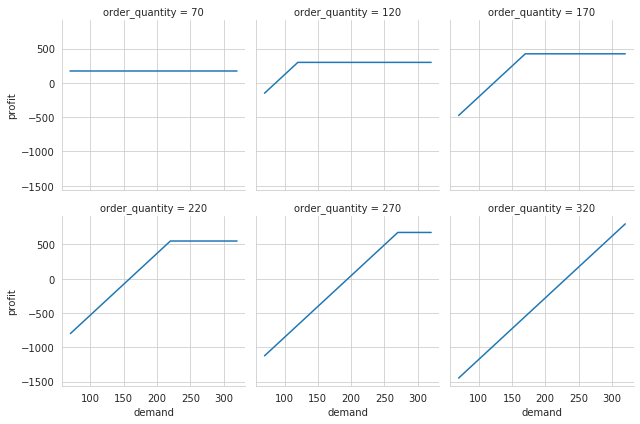

In [92]:
profit_dt_g = sns.FacetGrid(m6_dt1_df, col="order_quantity", sharey=True, col_wrap=3)
profit_dt_g = profit_dt_g.map(plt.plot, "demand", "profit")

#### Goal Seek
Find break even demand for an order quantity of 250 and all other inputs at their base values.

Seems like using the `compute_profit` function is the way to go. Should be able to generalize to mulitple dimensions to create efficient frontier type outputs.

https://stackoverflow.com/questions/14261474/how-do-i-write-a-function-that-returns-another-function

https://docs.python.org/3/library/functools.html#partial-objects

https://stackoverflow.com/questions/37052253/choose-which-variable-to-solve-for-python-root-finding-using-fsolve

Actually, as you'll see below, this is quite a hornet's nest of meta-programming caused by the need to partially freeze the function for use with scipy.optimize but in which we don't know in advance which parameter will be the free one.

Perhaps this would be easier with the OO version. That turned out to be pretty easy to use for data tables. ... Well, not seeing obvious way to do this with OO especially since the function I want to goal seek calls other methods within the model class. Thinking I need to not use scipy.optimize and just write it myself.

https://github.com/patrickwalls/mathematical-python/ - has nice implementation of various root finding methods

In [96]:
def bisection(f,a,b,N):
    '''Approximate solution of f(x)=0 on interval [a,b] by bisection method.

    Parameters
    ----------
    f : function
        The function for which we are trying to approximate a solution f(x)=0.
    a,b : numbers
        The interval in which to search for a solution. The function returns
        None if f(a)*f(b) >= 0 since a solution is not guaranteed.
    N : (positive) integer
        The number of iterations to implement.

    Returns
    -------
    x_N : number
        The midpoint of the Nth interval computed by the bisection method. The
        initial interval [a_0,b_0] is given by [a,b]. If f(m_n) == 0 for some
        midpoint m_n = (a_n + b_n)/2, then the function returns this solution.
        If all signs of values f(a_n), f(b_n) and f(m_n) are the same at any
        iteration, the bisection method fails and return None.

    Examples
    --------
    >>> f = lambda x: x**2 - x - 1
    >>> bisection(f,1,2,25)
    1.618033990263939
    >>> f = lambda x: (2*x - 1)*(x - 3)
    >>> bisection(f,0,1,10)
    0.5
    '''
    if f(a)*f(b) >= 0:
        print("Bisection method fails.")
        return None
    a_n = a
    b_n = b
    for n in range(1,N+1):
        m_n = (a_n + b_n)/2
        f_m_n = f(m_n)
        if f(a_n)*f_m_n < 0:
            a_n = a_n
            b_n = m_n
        elif f(b_n)*f_m_n < 0:
            a_n = m_n
            b_n = b_n
        elif f_m_n == 0:
            print("Found exact solution.")
            return m_n
        else:
            print("Bisection method fails.")
            return None
    return (a_n + b_n)/2

In [97]:
def goal_seek(model, obj_fn, target, by_changing, a, b, N=100):
    # TODO: Checking of inputs and outputs
    
    # Clone the model
    model_clone = copy.deepcopy(model)
    
    # The following bisection search is a direct adaptation of
    # https://www.math.ubc.ca/~pwalls/math-python/roots-optimization/bisection/
    # The changes include needing to use an object method instead of a global function
    # and the inclusion of a non-zero target value.
    
    setattr(model_clone, by_changing, a)
    f_a_0 = getattr(model_clone, obj_fn)()
    setattr(model_clone, by_changing, b)
    f_b_0 = getattr(model_clone, obj_fn)()
    
    if (f_a_0 - target) * (f_b_0 - target) >= 0:
        print("Bisection method fails.")
        return None
    
    a_n = a
    b_n = b
    for n in range(1, N+1):
        m_n = (a_n + b_n)/2
        
        setattr(model_clone, by_changing, m_n)
        f_m_n = getattr(model_clone, obj_fn)()
        
        setattr(model_clone, by_changing, a_n)
        f_a_n = getattr(model_clone, obj_fn)()
        
        setattr(model_clone, by_changing, b_n)
        f_b_n = getattr(model_clone, obj_fn)()

        if (f_a_n - target) * (f_m_n - target) < 0:
            a_n = a_n
            b_n = m_n
        elif (f_b_n - target) * (f_m_n - target) < 0:
            a_n = m_n
            b_n = b_n
        elif f_m_n == target:
            print("Found exact solution.")
            return (m_n, n)
        else:
            print("Bisection method fails.")
            return None
    
    return ((a_n + b_n)/2, n)

In [98]:
print(model1)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


In [99]:
model1.profit()

437.0

In [100]:
goal_seek(model1, 'profit', 0.0, 'demand', 100, 500, N=100)

Found exact solution.


(144.44444444444446, 51)

In [101]:
goal_seek(model1, 'profit', 0.0, 'selling_price', 1.0, 25.0, N=100)

Found exact solution.


(7.7357512953367875, 55)

## Attempt at non-OO version of Goal Seek

This got nasty but led down all kinds of interesting side paths having to do with partial function freezing, lambda functions, currying, function signatures and more.

In [102]:
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50
order_quantity = 200

profit_demand = partial(compute_profit, unit_cost=unit_cost, selling_price=selling_price,
                   unit_refund=unit_refund, order_quantity=order_quantity)

In order to dynamically change the calling order on compute_profit, which we need to do depending on the variable that is being treated as the "changing cell", we have to wrap it in a lambda function that has its args in the desired order and then wrap that with partial. Now we should be able to use this version in scipy.optimize.

Got idea from:

https://stackoverflow.com/questions/51583924/python-typeerror-multiple-arguments-with-functools-partial

If we don't do this, we get the following behavior and we can't use it in scipy.optimize

In [103]:
# print(profit_demand(190))

'''
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-106-0c7da8d554f8> in <module>
----> 1 print(profit_demand(190))

TypeError: compute_profit() got multiple values for argument 'unit_cost'
'''

"\n---------------------------------------------------------------------------\nTypeError                                 Traceback (most recent call last)\n<ipython-input-106-0c7da8d554f8> in <module>\n----> 1 print(profit_demand(190))\n\nTypeError: compute_profit() got multiple values for argument 'unit_cost'\n"

In [104]:
profit_demand_2 = partial(lambda d, uc, sp, uf, oq: compute_profit(uc, sp, uf, oq, d),
                          uc=unit_cost, sp=selling_price, 
                          uf=unit_refund,
                          oq=order_quantity)

In [105]:
print(profit_demand_2(190))
print(profit_demand(demand=190))

410.0
410.0


In [106]:
profit_demand.args

()

In [107]:
profit_demand.keywords

{'unit_cost': 7.5,
 'selling_price': 10.0,
 'unit_refund': 2.5,
 'order_quantity': 200}

In [108]:
profit_demand.func

<function __main__.compute_profit(unit_cost, selling_price, unit_refund, order_quantity, demand)>

In [109]:
profit_demand(demand=demand)

array([-670., -625., -580., -535., -490., -445., -400., -355., -310.,
       -265., -220., -175., -130.,  -85.,  -40.,    5.,   50.,   95.,
        140.,  185.,  230.,  275.,  320.,  365.,  410.,  455.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.])

In [110]:
demand

array([ 70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320])

In [111]:
profit_demand_2(demand)

array([-670., -625., -580., -535., -490., -445., -400., -355., -310.,
       -265., -220., -175., -130.,  -85.,  -40.,    5.,   50.,   95.,
        140.,  185.,  230.,  275.,  320.,  365.,  410.,  455.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.])

In [112]:
optimize.root_scalar(profit_demand_2, bracket=[0, 500])

      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 144.44444444444443

In [113]:
profit_demand_2?

Signature:      profit_demand_2(d, *, uc=7.5, sp=10.0, uf=2.5, oq=200)
Call signature: profit_demand_2(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function <lambda> at 0x7f7488f83ee0>, uc=7.5, sp=10.0, uf=2.5, oq=200)
File:           ~/anaconda3/envs/mginf/lib/python3.8/functools.py
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.


Ok, so for a given variable for which to goal seek, we can write a partial lambda function to do the goal seek. Now, how can we create a function that creates the partial lambda function and that takes as input the base `compute_profit` function and the name of the keyword arg representing the decision variable?

https://stackoverflow.com/questions/14261474/how-do-i-write-a-function-that-returns-another-function

https://en.wikipedia.org/wiki/Currying

In [114]:
compute_profit?

Signature:
compute_profit(
    unit_cost,
    selling_price,
    unit_refund,
    order_quantity,
    demand,
)
Docstring: Compute profit in bookstore model
File:      ~/Documents/teaching/adv_analytics/abm/notebooks/<ipython-input-78-30ab07516e02>
Type:      function


In [116]:
compute_profit.__doc__

'\n    Compute profit in bookstore model\n    '

In [117]:
compute_profit.__dict__

{}

https://docs.python.org/3/library/inspect.html

https://treyhunner.com/2018/04/keyword-arguments-in-python/

In [118]:

import inspect

In [119]:
inspect.getdoc(compute_profit)

'Compute profit in bookstore model'

Signature objects are important and powerful for function programming.

https://www.python.org/dev/peps/pep-0362/

In [120]:
inspect.signature(compute_profit)

<Signature (unit_cost, selling_price, unit_refund, order_quantity, demand)>

In [121]:
dir(inspect.signature(compute_profit))

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_bind',
 '_bound_arguments_cls',
 '_hash_basis',
 '_parameter_cls',
 '_parameters',
 '_return_annotation',
 'bind',
 'bind_partial',
 'empty',
 'from_builtin',
 'from_callable',
 'from_function',
 'parameters',
 'replace',
 'return_annotation']

In [122]:
sig = inspect.signature(compute_profit)
sig.parameters

mappingproxy({'unit_cost': <Parameter "unit_cost">,
              'selling_price': <Parameter "selling_price">,
              'unit_refund': <Parameter "unit_refund">,
              'order_quantity': <Parameter "order_quantity">,
              'demand': <Parameter "demand">})

In [123]:
sig.parameters['unit_cost']

<Parameter "unit_cost">

In [124]:
sig.parameters['unit_cost'].replace(default=100)

<Parameter "unit_cost=100">

In [134]:
#dir(sig.parameters)

In [126]:
for item in sig.parameters.items():
    print(item)
    print(item[1].name)
    print(item[1].default)

('unit_cost', <Parameter "unit_cost">)
unit_cost
<class 'inspect._empty'>
('selling_price', <Parameter "selling_price">)
selling_price
<class 'inspect._empty'>
('unit_refund', <Parameter "unit_refund">)
unit_refund
<class 'inspect._empty'>
('order_quantity', <Parameter "order_quantity">)
order_quantity
<class 'inspect._empty'>
('demand', <Parameter "demand">)
demand
<class 'inspect._empty'>


In [127]:
inspect.getsource(compute_profit)

"def compute_profit(unit_cost, selling_price, unit_refund, order_quantity, demand):\n    '''\n    Compute profit in bookstore model\n    '''\n    order_cost = unit_cost * order_quantity\n    sales_revenue = np.minimum(order_quantity, demand) * selling_price\n    refund_revenue = np.maximum(0, order_quantity - demand)\n    profit = sales_revenue + refund_revenue - order_cost\n    return profit\n"

In [128]:
inspect.getsourcelines(compute_profit)[0]

['def compute_profit(unit_cost, selling_price, unit_refund, order_quantity, demand):\n',
 "    '''\n",
 '    Compute profit in bookstore model\n',
 "    '''\n",
 '    order_cost = unit_cost * order_quantity\n',
 '    sales_revenue = np.minimum(order_quantity, demand) * selling_price\n',
 '    refund_revenue = np.maximum(0, order_quantity - demand)\n',
 '    profit = sales_revenue + refund_revenue - order_cost\n',
 '    return profit\n']

In [135]:
#inspect.getmembers(compute_profit)

In [130]:
var = "demand"
# Create dictionary of key word args for all but var 
# The parameters attribute is an OrderedDict (see PEP 362)
fixed_inputs = {key:value for (key, value) in sig.parameters.items() if
                   key != var}
var_input = {key:value for (key, value) in sig.parameters.items() if
                   key == var}

In [131]:
print(fixed_inputs)
print(var_input)

{'unit_cost': <Parameter "unit_cost">, 'selling_price': <Parameter "selling_price">, 'unit_refund': <Parameter "unit_refund">, 'order_quantity': <Parameter "order_quantity">}
{'demand': <Parameter "demand">}


https://stackoverflow.com/questions/938429/scope-of-lambda-functions-and-their-parameters

In [132]:
fixed_inputs = {'unit_cost': 7.5,
 'selling_price': 10.0,
 'unit_refund': 2.5,
 'order_quantity': 200}

def make_partial_profit(fn, fixed_inputs, var_input):
     
    partial(lambda d, uc, sp, uf, oq: compute_profit(uc, sp, uf, oq, d),
                          **fixed_inputs)

In [133]:
profit_demand_2 = partial(lambda d, uc, sp, uf, oq: compute_profit(uc, sp, uf, oq, d),
                          uc=unit_cost, sp=selling_price, 
                          uf=unit_refund,
                          oq=order_quantity)

#### Monte-carlo sim

We can do MC sim using both OO and non-OO versions of our model using the same ideas as we did for creating data tables. For the non-OO we can generate a vector of random demand realizations and then feed that vector to our `compute_profit` function. We'll end up with a vector of profits with the same number of elements as in our demand vector. Then we can analyze the results with statistics and histograms, for example.

Recently, numpy has updated their random variable generation routines. The details are at:

https://numpy.org/doc/stable/reference/random/index.html




The `scipy.stats` module contains a large number of probability distributions. Each has numerous functions for calculating things such as pdf or CDF values, quantiles, and various moments. There are also functions for generating random variates from these distributions. You can see the details at https://docs.scipy.org/doc/scipy/reference/stats.html.

Let's assume we want to model demand with a normal distribution. If you recall, we already initialized variables `demand_mean` and `demand_sd` with the mean and standard deviation of demand. We'll use these.

First we import the necessary function from `scipy.stats` and then we can generate the normally distributed random variates. I'm going to generate 1000 variates. To make sure this worked, we can create a histogram of the random variates and we expect it to be pretty bell-shaped. We can also overlay the normal density function for a normal distribution with the specified mean and standard deviation. 

In [136]:
print(f"Demand mean = {demand_mean}")
print(f"Demand sd = {demand_sd}")

Demand mean = 193
Demand sd = 40


In [137]:
from scipy.stats import norm

First we need to import the default random number generator and create a random generator variable. I'll use 4470 as the seed. This generator generates numbers uniformly between 0 and 1. Then we use it to generate random variates from whatever distribution we choose.

In [138]:
from numpy.random import default_rng
rg = default_rng(4470)
rg.random()

0.45855804438027437

In [139]:
demand_sim = rg.normal(demand_mean, demand_sd, 1000)

Obviously we are generating variates from a continuous distribution.

In [140]:
demand_sim[:10]

array([217.03616307, 133.37168121, 231.54405167, 215.05711803,
       183.66669223, 268.28497816, 255.99191635, 188.58125604,
       164.62174798, 170.1384389 ])

If we want integer valued demands, we can simply round the values.

In [141]:
demand_sim = np.around(rg.normal(demand_mean, demand_sd, 1000))
demand_sim[:10]

array([218., 203., 186., 203., 215., 151., 255., 176., 223., 252.])

Before plotting the histogram, let's compute basic summary stats for our vector of random demands.

In [142]:
print(f"Mean demand = {demand_sim.mean():.3f}, Std dev demand = {demand_sim.std():.3f}")

Mean demand = 192.056, Std dev demand = 40.170


Now let's use scipy to create a normal random variable instance with the mean and standard deviation based on `demand_mean` and `demand_sd`. Note the data type. Then we'll be able to use its built in `pdf` method to plot its density and its `ppf` method to get percentiles to use for our x-axis limits.

In [143]:
rv_normal = norm(loc=demand_mean, scale=demand_sd)
print(type(rv_normal))

<class 'scipy.stats._distn_infrastructure.rv_frozen'>


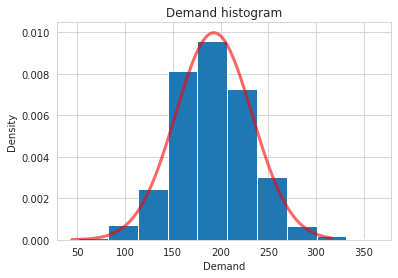

In [144]:
plt.title("Demand histogram")
plt.xlabel("Demand")
plt.ylabel("Density")
plt.hist(demand_sim, density=True);

x_normal = np.linspace(rv_normal.ppf(0.0001),
                rv_normal.ppf(0.999), 500)

plt.plot(x_normal, rv_normal.pdf(x_normal),
       'r-', lw=3, alpha=0.6, label='Normal pdf');

Now that we can generate random demands, we can "simulate" by simply passing in the vector of random demands to the `compute_profit` function (all the other model inputs are held fixed at their current values. Let's remind ourselves of these values.

In [145]:
message = f"unit_cost: {unit_cost} \n" \
          f"selling_price: {selling_price} \n" \
          f"unit_refund: {unit_refund} \n" \
          f"order_quantity: {order_quantity}"

print(message)

unit_cost: 7.5 
selling_price: 10.0 
unit_refund: 2.5 
order_quantity: 200


Again, note how we use a list comprehension to evaluate profit for each demand realization. This is exactly the same way we did the non-OO 1-way data table above. If we have multiple random inputs we cannot use multiple for statements as we don't want the cross product of the random number vectors. Instead we'd need to zip them up into tuples.

In [57]:
alpha = [1, 2, 3]
beta = [10, 20, 30]

for t in zip(alpha, beta):
    print(t)

(1, 10)
(2, 20)
(3, 30)


Let's wrap the resulting list with the pandas `Series` constructor so that we can use some of pandas built in analysis tools such as the `describe` method.

In [146]:
profit_sim = pd.Series([(compute_profit(unit_cost, selling_price, 
                              unit_refund, order_quantity, d)) 
               for d in demand_sim])



In [147]:
profit_sim.describe()

count    1000.000000
mean      317.399000
std       228.756476
min      -841.000000
25%       191.750000
50%       419.000000
75%       500.000000
max       500.000000
dtype: float64

The *Flaw of Averages* shows up here (compare mean of sim output to the profit we got by replacing demand with mean demand).

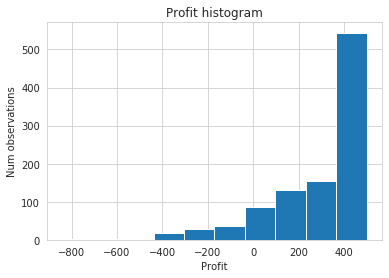

In [148]:
plt.title("Profit histogram")
plt.xlabel("Profit")
plt.ylabel("Num observations")
plt.hist(profit_sim, density=False);


In [149]:
from scipy import stats

In [150]:
# Probability between -200, 200
print(stats.percentileofscore(profit_sim, 200))
print(stats.percentileofscore(profit_sim, -200))
print(stats.percentileofscore(profit_sim, 200) - stats.percentileofscore(profit_sim, -200))

26.2
4.0
22.2


In [151]:
cdf = stats.cumfreq(profit_sim)

In [152]:
x = cdf.lowerlimit + np.linspace(0, cdf.binsize*cdf.cumcount.size,
                                 cdf.cumcount.size)

(-915.5, 574.5)

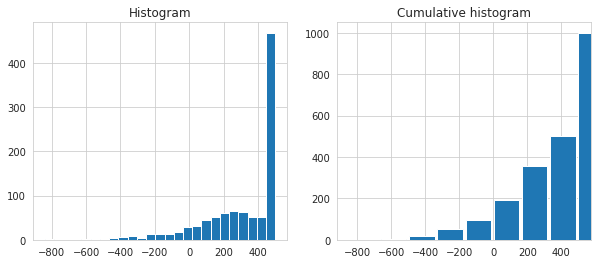

In [153]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(profit_sim, bins=25)
ax1.set_title('Histogram')
ax2.bar(x, cdf.cumcount, width=cdf.binsize)
ax2.set_title('Cumulative histogram')
ax2.set_xlim([x.min(), x.max()])

## Repeat simulation using OO approach
Just as we leveraged our non-OO data table approach for simulation, let's do the same for the OO version. We should be able to leverage scikit-learn's `ParameterGrid` function for optional scenario generation (think RiskSimTable). We don't want to use `ParameterGrid` for the random inputs as we don't want all combinations of them - we just want to evaluate one replication per row.

In [154]:
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50

order_quantity = 200

demand_mean = 193
demand_sd = 40

demand = demand_mean

In [155]:
model2 = BookstoreModel(unit_cost=unit_cost, 
                        selling_price=selling_price,
                        unit_refund=unit_refund,
                        order_quantity=order_quantity,
                        demand=demand)

In [156]:
random_inputs = {'demand': np.around(rg.normal(demand_mean, demand_sd, 100))}
scenario_inputs = {'order_quantity': np.arange(70, 321, 50)}
sim_outputs = ['profit']

In [157]:
print(model2)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


In [158]:
# Yes, this works. Now let's see if it makes sense to do the simulation this way. Looping over scenario inputs 
# but using vector assignment for the random inputs.
# model2.update(random_inputs)

In [159]:
print(model2)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


In [160]:
list(ParameterGrid(scenario_inputs))

[{'order_quantity': 70},
 {'order_quantity': 120},
 {'order_quantity': 170},
 {'order_quantity': 220},
 {'order_quantity': 270},
 {'order_quantity': 320}]

In [161]:
def simulate(model, random_inputs, outputs, scenario_inputs=None, keep_random_inputs=False):
    # TODO: Checking of inputs and outputs
    
    # Clone the model
    model_clone = copy.deepcopy(model)
    
    # Update clone with random_inputs
    #for rnd_inp in random_inputs:
    model_clone.update(random_inputs)
    
    if keep_random_inputs:
        scenario_base_vals = vars(model_clone)
    else:
        scenario_base_vals = vars(model)
    
    
    scenario_num = 1
    scenario_results = []
    
    # Create parameter grid
    if scenario_inputs is not None:
        sim_param_grid = list(ParameterGrid(scenario_inputs))
        
        for params in sim_param_grid:
            model_clone.update(params)
            result = {}
            scenario_vals = copy.copy(params)
            result['scenario_base_vals'] = scenario_base_vals
            result['scenario_num'] = scenario_num
            result['scenario_vals'] = scenario_vals
            raw_output = {}
            for output_name in outputs:
                output_array = getattr(model_clone, output_name)()
                raw_output[output_name] = output_array
                
            result['output'] = raw_output
            scenario_results.append(result)
            scenario_num += 1
                
        return scenario_results

    else:
        results = []
        result = {}

        result['scenario_base_vals'] = scenario_base_vals
        result['scenario_num'] = scenario_num
        result['scenario_vals'] = {}
        
        raw_output = {}
        for output_name in outputs:
            output_array = getattr(model_clone, output_name)()
            raw_output[output_name] = output_array
            
        result['output'] = raw_output  
        results.append(result)

        return results

In [162]:
print(model2)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


In [163]:
model2_results = simulate(model2, random_inputs, sim_outputs, scenario_inputs)

In [164]:
model2_results[0].keys()

dict_keys(['scenario_base_vals', 'scenario_num', 'scenario_vals', 'output'])

In [170]:
for scenario in model2_results:
    print(scenario['scenario_num'])

1
2
3
4
5
6


In [166]:
model2_results[0]['scenario_vals']

{'order_quantity': 70}

In [167]:
print(type(model2_results[0]['output']))
model2_results[0]['output']

<class 'dict'>


{'profit': array([175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
        175.])}

In [168]:
for scenario in model2_results:
    print(scenario['scenario_num'], scenario['scenario_vals'], type(scenario['output']), scenario['output']['profit'].mean())

1 {'order_quantity': 70} <class 'dict'> 175.0
2 {'order_quantity': 120} <class 'dict'> 298.74
3 {'order_quantity': 170} <class 'dict'> 356.15
4 {'order_quantity': 220} <class 'dict'> 252.91
5 {'order_quantity': 270} <class 'dict'> -11.88
6 {'order_quantity': 320} <class 'dict'> -329.5


In [169]:
model2_results[0]

{'scenario_base_vals': {'unit_cost': 7.5,
  'selling_price': 10.0,
  'unit_refund': 2.5,
  'order_quantity': 200,
  'demand': 193},
 'scenario_num': 1,
 'scenario_vals': {'order_quantity': 70},
 'output': {'profit': array([175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175., 175., 175., 175., 175., 175., 175., 175., 175., 175., 175.,
         175.])}}

In [193]:
for scenario in model2_results:
    for key in scenario['output'].keys():
        print (key)
    

profit
profit
profit
profit
profit
profit


Let's write a gather results function to turn results object into analysis ready DataFrame.

In [ ]:
def gather_sim_results(results):
    

Hmmm, so we have a result object but need to get them into a nicely structured DataFrame to make stats and plotting easy. Perhaps we can go back to the ParameterGrid / DataTable approach if we zip the random vectors into tuples and then create the grid. Then we get data table output for free.

https://realpython.com/python-zip-function/

In [67]:
demand_sim = np.around(rg.normal(demand_mean, demand_sd, 100))
unit_cost_sim = np.around(rg.normal(unit_cost, 1.0, 100))

In [71]:
random_input_tuples = list(zip(demand_sim, unit_cost_sim))

print(random_input_tuples[:10])

[(207.0, 8.0), (225.0, 7.0), (113.0, 8.0), (249.0, 7.0), (146.0, 8.0), (187.0, 7.0), (290.0, 8.0), (177.0, 6.0), (201.0, 7.0), (119.0, 8.0)]


Ah, doesn't seem worth it.

#### Sim table of profit vs order quantity

In [196]:
# Create data table (list of tuples)
order_quantity_range = np.arange(100, 400, 25)
sim_table_1 = [(oq, compute_profit(unit_cost, selling_price, unit_refund, oq, d)) 
for oq in order_quantity_range for d in demand_sim]

# Convert to dataframe

stbl_1_df = pd.DataFrame(sim_table_1, columns=['OrderQuantity', 'Profit'])

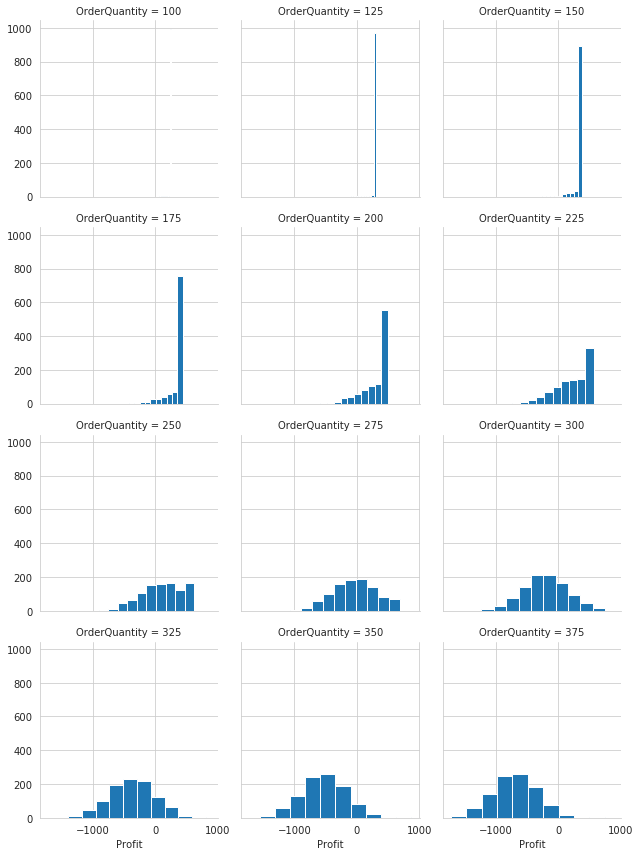

In [198]:
profit_histo_g = sns.FacetGrid(stbl_1_df, col="OrderQuantity", sharey=True, col_wrap=3)
profit_histo_g = profit_histo_g.map(plt.hist, "Profit")

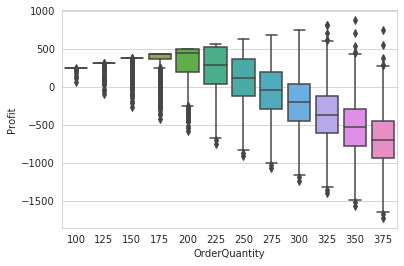

In [199]:
profit_box_g = sns.boxplot(x="OrderQuantity", y="Profit", data=stbl_1_df)